<a href="https://colab.research.google.com/github/Woori60/Auto-star-rating-tagging-method-using-SNS-review-data/blob/master/personal_111%20data_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# GPU로 바꾸기

In [0]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#표제화 X
#다시 돌릴 필요 X
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import re

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

n=WordNetLemmatizer()

tx1 = ''
tx2 = ''
remove_list = ['NN', 'IN', 'DT', 'MD', 'TO', 'PR', 'CC', 'WD', 'WP']

with open('/content/drive/My Drive/pretrained/user_review_15.json', 'rt', encoding='UTF-8') as f:
    for line in f:
        lineobj = json.loads(line)
        tx1 = lineobj['text']       
        tx3 = tx1.lower()
        word_tokens = word_tokenize(tx3)

        result = []
        words = []
        nword = []

        tag_l = pos_tag(word_tokens)

        for w in tag_l:
          if w[1][:2] in remove_list:
            continue
          else:
            words.append(w[0])
        #print(words)
        
        stop_words = set(stopwords.words('english'))
        stop_words.update(['\'re', '\'d', '\'t', '\'ll', '\'ve', '\'s','\'m', '!', '.', ',', '/', '?', '\"', '@', '%', '&', '*', '=','(',')','{','}', '-', '--', 'u', '...','$', '#', '*', '@', ':', ';', '[',']','~']) 
        stop_words.remove('not')
        
        for w in words:
          if w == 'n\'t':
            w = 'not'
          if w not in stop_words:
            a = re.sub('[^a-zA-Z ]', '', w)
            if a != '':
              result.append(a) #result에 불용어 제거된 tokens 존재
        
        newresult=[]
        for token in result:
          shortword = re.compile(r'\W*\b\w{1,2}\b')
          tk = shortword.sub('', token)
          if tk != '':
            newresult.append(tk)
        #print(newresult, '\n')

        tmpresult=[]
        for review in newresult:
          if review[:3] != 'www':
            tmpresult.append(review)

        #print(tmpresult)
        newresult = tmpresult

        # 길이 14 이상
        notremove = ['unpretentious', 'unfortunately', 'approximately', 'complimentary', 'uncomfortable','disappointing']
        lenreview = []
        for review in newresult:
          if len(review) >= 13 and review not in notremove :
            continue
          else:
            lenreview.append(review)

        newresult = lenreview

        with open('/content/drive/My Drive/remove_only.txt', 'a', encoding='UTF-8') as mf:
          mf.write('[\n')
          mf.write('\n'.join(newresult))
          mf.write('\n]\n')
    
f.close()          


'\nimport json\nimport nltk\nfrom nltk.corpus import stopwords\nfrom nltk.tokenize import word_tokenize\nfrom nltk.stem import WordNetLemmatizer\nfrom nltk.tag import pos_tag\nimport re\n\nnltk.download(\'punkt\')\nnltk.download(\'averaged_perceptron_tagger\')\nnltk.download(\'wordnet\')\nnltk.download(\'stopwords\')\n\nn=WordNetLemmatizer()\n\ntx1 = \'\'\ntx2 = \'\'\nremove_list = [\'NN\', \'IN\', \'DT\', \'MD\', \'TO\', \'PR\', \'CC\', \'WD\', \'WP\']\n\nwith open(\'/content/drive/My Drive/pretrained/user_review_15.json\', \'rt\', encoding=\'UTF-8\') as f:\n    for line in f:\n        lineobj = json.loads(line)\n        tx1 = lineobj[\'text\']       \n        tx3 = tx1.lower()\n        word_tokens = word_tokenize(tx3)\n\n        result = []\n        words = []\n        nword = []\n\n        tag_l = pos_tag(word_tokens)\n\n        for w in tag_l:\n          if w[1][:2] in remove_list:\n            continue\n          else:\n            words.append(w[0])\n        #print(words)\n      

In [0]:
# 데이터 준비
import re
import nltk
from gensim.models import Word2Vec
import os
import numpy as np
import json
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.optimizers import SGD

# token list 읽기 - 전체(이후에 분할)
from keras_preprocessing.text import Tokenizer


# label 준비(1, 5)
labelAll = []
with open('/content/drive/My Drive/pretrained/user_review_15.json', 'rt', encoding='UTF-8') as f:
    for line in f:
        lineobj = json.loads(line)
        star = lineobj['stars']
        if star == 1 :
          labelAll.append(0)
        elif star == 5:
          labelAll.append(1)

f.close()
label = np.array(labelAll)
label = np_utils.to_categorical(label, num_classes=2)

# data 준비
result = []
dataAll2 = []
with open('/content/drive/My Drive/remove_only.txt', 'rt', encoding='UTF-8') as mf:
  while True:
    temp = mf.readline()
    if not temp:
      break
    if temp == '[\n':
      continue
    elif temp == ']\n':
      dataAll2.append(result)
      result = []
      continue
    else:
      l = len(temp)
      word = temp[0:l-1]
      result.append(word)

mf.close()

print('label size : ', len(label))
print('data size : ', len(dataAll2))

Using TensorFlow backend.


label size :  111
data size :  111


In [0]:
#다시 돌릴 필요X

#word2vec 모델 생성
embedding_dim = 300

#train word2vec model
embedding_model = Word2Vec(sentences=dataAll2, size=embedding_dim, min_count=2, window=4, iter=200, workers=4, sg=1) #size = embedding_dim = 80

# load model
filename = '/content/drive/My Drive/pretrained/GoogleNews-vectors-negative300.bin'
embedding_model.intersect_word2vec_format(filename, binary=True)

# save model
filename = '/content/drive/My Drive/w2v_model_intersect_remove_15_final.txt'
embedding_model.wv.save_word2vec_format(filename, binary=False)


"\n#word2vec 모델 생성\nembedding_dim = 300\n\n#train word2vec model\nembedding_model = Word2Vec(sentences=dataAll2, size=embedding_dim, min_count=2, window=4, iter=200, workers=4, sg=1) #size = embedding_dim = 80\n\n# load model\nfilename = '/content/drive/My Drive/pretrained/GoogleNews-vectors-negative300.bin'\nembedding_model.intersect_word2vec_format(filename, binary=True)\n\n# save model\nfilename = '/content/drive/My Drive/w2v_model_intersect_remove_15_final.txt'\nembedding_model.wv.save_word2vec_format(filename, binary=False)\n"

In [0]:
# load pretrained model
embeddings_index = {}
file = open(os.path.join('', '/content/drive/My Drive/w2v_model_intersect_remove_15_final.txt'), encoding="utf-8")
for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:])
  embeddings_index[word] = coefs
file.close()

In [0]:
# 전체 데이터 학습(6)/검증(1)/테스트(3)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import keras

import numpy as np

# train_test_split
# Stratified하게 트레이닝셋과 테스트셋으로 나눈다(1회만 실시)
from sklearn.model_selection import train_test_split
seed = 777
dataAll2 = np.array(dataAll2)
train_index, test_index = train_test_split(np.array(range(dataAll2.shape[0])), shuffle=True, stratify=label, test_size=0.3, random_state=seed)

x_train, X_test = dataAll2[train_index], dataAll2[test_index]
y_train, Y_test = label[train_index], label[test_index]
print("-"*40)

print('테스트 : ', len(X_test), ', ', len(Y_test))

train_index, valid_index = train_test_split(np.array(range(x_train.shape[0])), shuffle=True, stratify=y_train, test_size=0.1, random_state=seed)

X_train, X_valid = x_train[train_index], x_train[valid_index]
Y_train, Y_valid = y_train[train_index], y_train[valid_index]
print("-"*40)
print('학습 : ', len(X_train), ', ', len(Y_train))
print("-"*40)
print('검증 : ', len(X_valid), ', ', len(Y_valid))
print("-"*40)


----------------------------------------
테스트 :  34 ,  34
----------------------------------------
학습 :  69 ,  69
----------------------------------------
검증 :  8 ,  8
----------------------------------------


In [0]:
# max_length - train data
train_sum=0
train_count = len(X_train)
for sent in X_train :
  train_sum = train_sum+len(sent)

test_count = len(X_test)
for sent in X_test :
  train_sum = train_sum+len(sent)

valid_count = len(X_valid)
for sent in X_test :
  train_sum = train_sum+len(sent)

MAX = train_sum / (train_count + test_count + valid_count)

MAX = int(MAX)
print(MAX)

49


In [0]:
tmp_train=[]
for review in X_train:
  if len(review) > 49:
    tmp_train.append(review[0:50])
  else:
    tmp_train.append(review)
X_train = tmp_train

tmp_test=[]
for review in X_test:
  if len(review) > 49:
    tmp_test.append(review[0:50])
  else:
    tmp_test.append(review)
X_test = tmp_test


tmp_valid=[]
for review in X_valid:
  if len(review) > 49:
    tmp_valid.append(review[0:50])
  else:
    tmp_valid.append(review)
X_valid = tmp_valid

In [0]:
print(len(X_train))
print(len(X_test))
print(len(X_valid))

69
34
8


In [0]:

#########################################
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(dataAll2)
sequences_obj = tokenizer_obj.texts_to_sequences(dataAll2)
word_index = tokenizer_obj.word_index
num_words = len(word_index)+1
embedding_dim = 300
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
  if i > num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None :
    # words not found in embedding index will be all-zeros
    embedding_matrix[i] = embedding_vector
##########################################


# vec - train data
tokenizer_obj_train = Tokenizer()
tokenizer_obj_train.fit_on_texts(X_train)
sequences_train = tokenizer_obj_train.texts_to_sequences(X_train)

# vec - test data
tokenizer_obj_test = Tokenizer()
tokenizer_obj_test.fit_on_texts(X_test)
sequences_test = tokenizer_obj_test.texts_to_sequences(X_test)

# vec - valid data
tokenizer_obj_valid = Tokenizer()
tokenizer_obj_valid.fit_on_texts(X_valid)
sequences_valid = tokenizer_obj_valid.texts_to_sequences(X_valid)


# pad_sequences_train
word_index_train = tokenizer_obj_train.word_index
print('Found %s unique tokens.' % len(word_index_train))

review_pad_train = pad_sequences(sequences_train, maxlen=MAX, padding = 'post')         # test data max가 더 커서 그 값으로 train, test 둘다 패딩
sentiment_train = Y_train

print('Shape of review tensor:', review_pad_train.shape)
print('Shape of sentiment tensor:', sentiment_train.shape)

num_words_train = len(word_index_train)+1
embedding_dim = 300
embedding_matrix_train = np.zeros((num_words_train, embedding_dim))

for word, i in word_index_train.items():
  if i > num_words_train:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None :
    # words not found in embedding index will be all-zeros
    embedding_matrix_train[i] = embedding_vector

print('train data word size : ',num_words_train)

# pad_sequences_test
word_index_test = tokenizer_obj_test.word_index
print('Found %s unique tokens(test).' % len(word_index_test))

review_pad_test = pad_sequences(sequences_test, maxlen=MAX, padding = 'post')   # test data max가 더 커서 그 값으로 train, test 둘다 패딩
sentiment_test = Y_test

print('Shape of review tensor(test):', review_pad_test.shape)
print('Shape of sentiment tensor(test):', sentiment_test.shape)

num_words_test = len(word_index_test)+1
embedding_matrix_test = np.zeros((num_words_test, embedding_dim))

for word, i in word_index_test.items():
  if i > num_words_test:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None :
    # words not found in embedding index will be all-zeros
    embedding_matrix_test[i] = embedding_vector

print('test data word size : ',num_words_test)

# pad_sequences_valid
word_index_valid = tokenizer_obj_valid.word_index
print('Found %s unique tokens(valid).' % len(word_index_valid))

review_pad_valid = pad_sequences(sequences_valid, maxlen=MAX, padding = 'post')   # test data max가 더 커서 그 값으로 train, test 둘다 패딩
sentiment_valid = Y_valid

print('Shape of review tensor(valid):', review_pad_valid.shape)
print('Shape of sentiment tensor(valid):', sentiment_valid.shape)

num_words_valid = len(word_index_valid)+1
embedding_matrix_valid = np.zeros((num_words_valid, embedding_dim))

for word, i in word_index_valid.items():
  if i > num_words_valid:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None :
    # words not found in embedding index will be all-zeros
    embedding_matrix_valid[i] = embedding_vector

print('valid data word size : ',num_words_valid)

Found 942 unique tokens.
Shape of review tensor: (69, 49)
Shape of sentiment tensor: (69, 2)
train data word size :  943
Found 535 unique tokens(test).
Shape of review tensor(test): (34, 49)
Shape of sentiment tensor(test): (34, 2)
test data word size :  536
Found 195 unique tokens(valid).
Shape of review tensor(valid): (8, 49)
Shape of sentiment tensor(valid): (8, 2)
valid data word size :  196


In [0]:
### code part3 - 훈련 모델

from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import Dense, Activation, Flatten, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

#model.reset_states()
# define model
# In the below code, the only change from previous model is using the embedding_matrix as input to the Embedding layer and setting trainable = False, since the embedding is already learned.

model = Sequential()
model.add(Embedding(num_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=MAX, trainable = False))    #test data max length로 맞춤
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=16 , kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# try using different optimizers and different optimizer configs
sgd = SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 49, 300)           402300    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 47, 16)            14416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 16)            528       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 16)            0         
____________________________________

In [0]:
result = model.fit(review_pad_train, sentiment_train, batch_size=6, epochs=30, validation_data=(review_pad_valid, sentiment_valid), verbose=1)




Train on 69 samples, validate on 8 samples
Epoch 1/30





69/69 [==============================] - 2s 35ms/step - loss: 0.6976 - acc: 0.4638 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/30
69/69 [==============================] - 0s 2ms/step - loss: 0.6835 - acc: 0.6232 - val_loss: 0.6976 - val_acc: 0.5000
Epoch 3/30
69/69 [==============================] - 0s 2ms/step - loss: 0.6505 - acc: 0.6667 - val_loss: 0.7072 - val_acc: 0.4375
Epoch 4/30
69/69 [==============================] - 0s 2ms/step - loss: 0.5748 - acc: 0.8623 - val_loss: 0.7225 - val_acc: 0.4375
Epoch 5/30
69/69 [==============================] - 0s 2ms/step - loss: 0.3496 - acc: 0.9565 - val_loss: 0.7997 - val_acc: 0.5000
Epoch 6/30
69/69 [==============================] - 0s 2ms/step - loss: 0.1284 - acc: 0.9855 - val_loss: 0.9579 - val_acc: 0.5000
Epoch 7/30
69/69 [==============================] - 0s 2ms/step - loss: 0.0580 - acc: 0.9855 - val_loss: 1.4566 - val_acc: 0.5000
Epoch 8/30
69/69 [====================

34/34 [==============================] - 0s 2ms/step
Accuracy: 55.882352


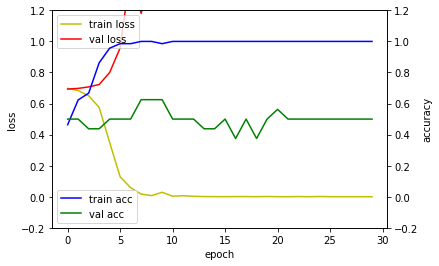

In [0]:
#loss, accuracy = model.evaluate(padded_sentences_test, test_label, verbose=1)
loss, accuracy = model.evaluate(review_pad_test, sentiment_test, batch_size=6, verbose=1)
print('Accuracy: %f' % (accuracy*100))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(result.history['loss'], 'y', label='train loss')
loss_ax.plot(result.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(result.history['acc'], 'b', label='train acc')
acc_ax.plot(result.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [0]:
# save model - 파일명에 정확도.

model.save('/content/drive/My Drive/final/111_%.2f.h5' % (accuracy*100))


https://lsjsj92.tistory.com/353

리뷰당 Max 패딩 길이는 긴데. 정작 대부분의 리뷰의 길이는 짧음.
같은 레이블(별점)을 갖는 리뷰들을 각각 3~5개?씩 합쳐보는 건 어떤지?


=> 우리 리뷰의 경우도  Max=142 길이로 zero 패딩해뒀는데
출력해보니 대부분의 리뷰는 XX 두자리수 길이였음.(대략 20~30)
